In [1]:
import pandas as pd

In [5]:
events = pd.read_csv("./data/raw/eth_cbbtc_usdc.csv")
events["date"] = events["datetime"].astype(str).str[:10]
events.head(2)

,hash,type,timestamp,user_address,assets,assets_usd,market,datetime,market_address,date
0,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,2024-09-12
1,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,2024-09-12


In [6]:
events["type"].value_counts()

type
MarketSupply                21787
MarketWithdraw              18987
MarketBorrow                 3044
MarketSupplyCollateral       2629
MarketRepay                  1809
MarketWithdrawCollateral     1001
Name: count, dtype: int64

In [7]:
borrows = events[events["type"] == "MarketBorrow"]
supplys = events[events["type"] == "MarketSupply"]


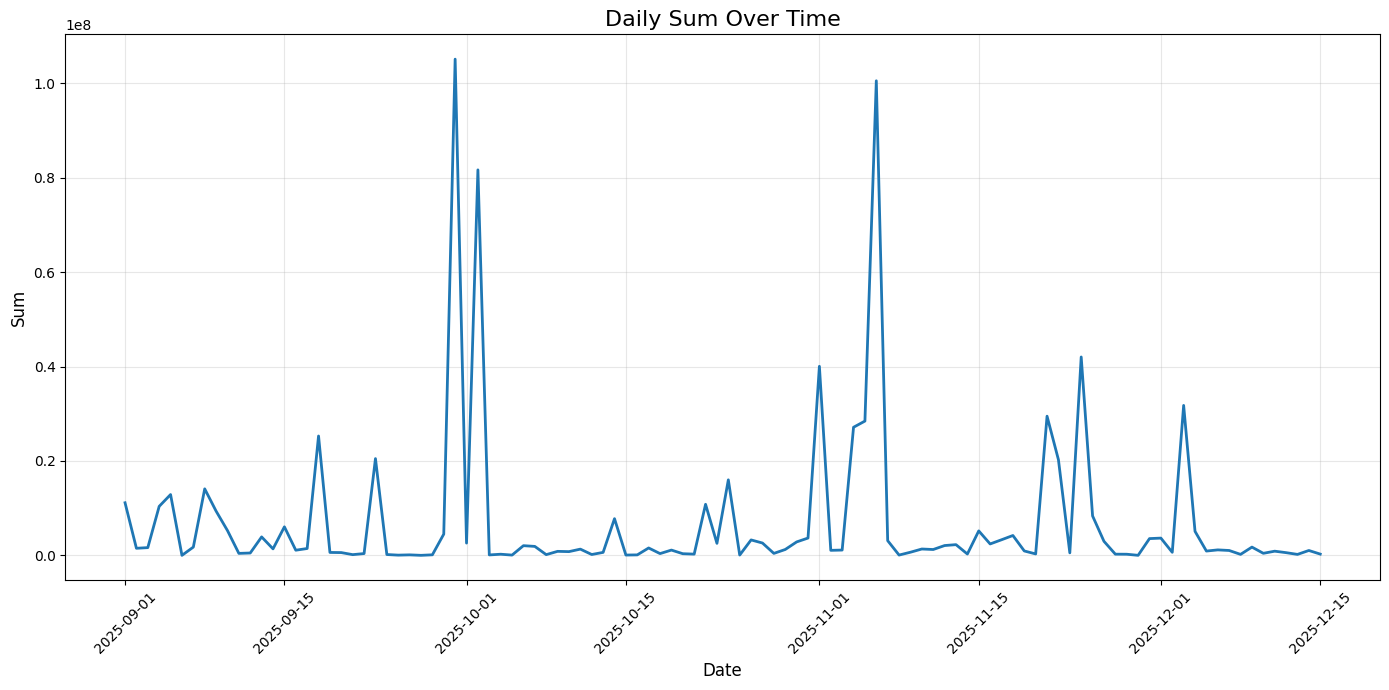

In [23]:
import matplotlib.pyplot as plt

def plot_daily_sum(df_orig, col="assets_usd", cutoff=None):
    df = df_orig.copy().fillna(0)
    if cutoff is not None:
        df = df[df["date"] >= cutoff]
    df['date'] = pd.to_datetime(df['date'])
    daily_df = df.groupby('date')[col].sum().reset_index()
    
    plt.figure(figsize=(14, 7))
    plt.plot(daily_df['date'], daily_df[col], linewidth=2)
    
    plt.title('Daily Sum Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sum', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
plot_daily_sum(
    borrows,
    cutoff="2025-09-01",
)

In [15]:
borrows[borrows["date"] == "2025-12-14"]["assets_usd"].sum()
events["type"].value_counts()

type
MarketSupply                21787
MarketWithdraw              18987
MarketBorrow                 3044
MarketSupplyCollateral       2629
MarketRepay                  1809
MarketWithdrawCollateral     1001
Name: count, dtype: int64

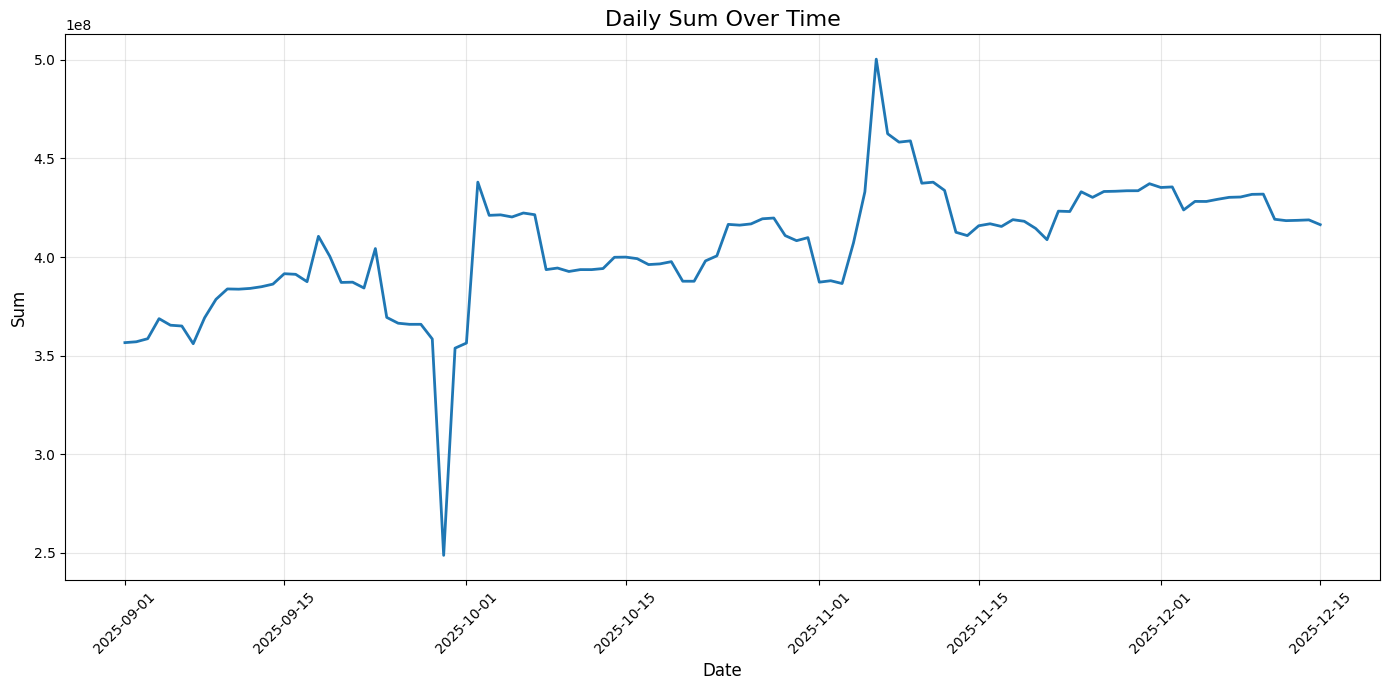

In [24]:
def calculate_total_borrow(df):
    df = df.copy().fillna(0)
    df = df[df["type"].isin(["MarketSupply", "MarketWithdraw", "MarketBorrow", "MarketRepay"])]
    df = df.sort_values('date')
    
    pivot = df.pivot_table(
        index='date',
        columns='type',
        values='assets_usd',
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    pivot['cumulative_borrow'] = pivot['MarketBorrow'].cumsum()    
    pivot['cumulative_repay'] = pivot['MarketRepay'].cumsum()    
    pivot['total_borrow'] = pivot['cumulative_borrow'] - pivot['cumulative_repay']
    
    return pivot[['date', 'total_borrow']]

cum_borrow = calculate_total_borrow(events)

plot_daily_sum(
    cum_borrow,
    col="total_borrow",
    cutoff="2025-09-01",
)

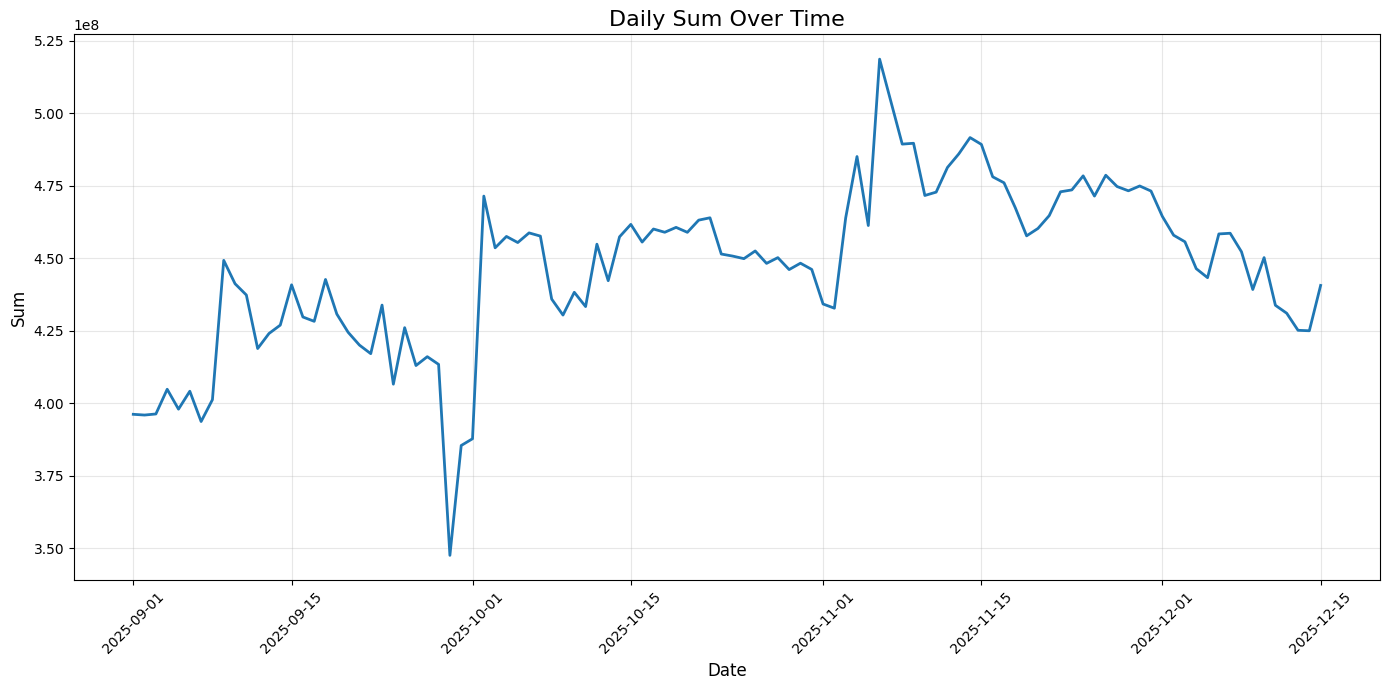

In [25]:
def calculate_total_supply(df):
    df = df.copy().fillna(0)
    df = df[df["type"].isin(["MarketSupply", "MarketWithdraw", "MarketBorrow", "MarketRepay"])]
    df = df.sort_values('date')
    
    pivot = df.pivot_table(
        index='date',
        columns='type',
        values='assets_usd',
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    pivot['cumulative_supply'] = pivot['MarketSupply'].cumsum()    
    pivot['cumulative_withdraw'] = pivot['MarketWithdraw'].cumsum()    
    pivot['total_supply'] = pivot['cumulative_supply'] - pivot['cumulative_withdraw']
    
    return pivot[['date', 'total_supply']]

cum_supply = calculate_total_supply(events)

plot_daily_sum(
    cum_supply,
    col="total_supply",
    cutoff="2025-09-01",
)